## Import Movie Lens Data Base

In [3]:
import pandas as pd
import numpy as np

In [4]:
#importar databasese Movie Lens e checar tamanhos
data_path = '../raw_data/ml-25m/'
g_scores = pd.read_csv(data_path + 'genome-scores.csv')#, nrows = 1000000)
g_tags = pd.read_csv(data_path +'genome-tags.csv')#, nrows = 1000000)
links = pd.read_csv(data_path + 'links.csv')
movies = pd.read_csv(data_path + 'movies.csv')
ratings = pd.read_csv(data_path + 'ratings.csv') #nrows = 1000000)
tags = pd.read_csv(data_path + 'tags.csv')

# Test with Collaborative filtering model

Collaborative filtering based recommendation engine is a family of algorithms that tries to find similar users based on similar preferences, actions and activities . It then looks at the movies for one user and recommends it to a similar user. Let’s take for example user A who is similar to user B, we know they are both similar because they both like the same video games, comic books, etc., if user A has seen a movie that user B hasn’t, then this recommendation engine will recommend that movie to user B.

In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


## KMeans and Sparse Matrix

(0.0, 200.0)

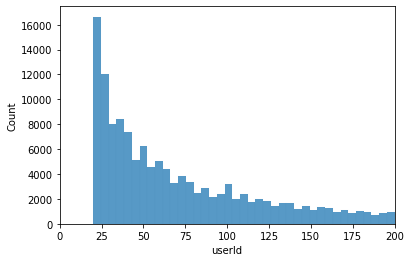

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(x=ratings.userId.value_counts())
plt.xlim(0,200)

In [15]:
ratings['number_reviews'] = ratings.userId.value_counts()
ratings = ratings.dropna(axis=0, subset=['number_reviews'])
ratings.head()

,userId,movieId,rating,timestamp,number_reviews
1,1,306,3.5,1147868817,70.0
2,1,307,5.0,1147868828,184.0
3,1,665,5.0,1147878820,656.0
4,1,899,3.5,1147868510,242.0
5,1,1088,4.0,1147868495,101.0


In [16]:
ratings_1 = ratings.loc[(ratings['number_reviews'] == 50)]

ratings_1.shape

(1418, 5)

In [17]:
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

movie_c = CategoricalDtype(sorted(ratings_1.movieId.unique()), ordered=True)
user_c = CategoricalDtype(sorted(ratings_1.userId.unique()), ordered=True)

row = ratings_1.userId.astype(user_c).cat.codes
col = ratings_1.movieId.astype(movie_c).cat.codes

sparse_matrix = csr_matrix((ratings_1["rating"], (row, col)), \
                           shape=(user_c.categories.size, movie_c.categories.size))

df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, index=user_c.categories, columns=movie_c.categories)
df.head()

,1,5,6,7,10,11,14,16,18,19,...,173639,173941,176371,177607,180497,188043,189203,194448,195327,203519
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
from sklearn.cluster import MiniBatchKMeans, KMeans

mbkm = KMeans(n_clusters=100)
mbkm.fit(sparse_matrix)

print('Number of ones:',(pd.Series(mbkm.labels_).value_counts() == 1).sum())
pd.Series(mbkm.labels_).value_counts()

Number of ones: 82


38    425
68      8
57      5
95      4
60      4
     ... 
64      1
65      1
66      1
67      1
0       1
Length: 100, dtype: int64

# Training on New Database

In [20]:
ratings = ratings.merge(movies[['movieId','title']],on='movieId')
ratings.head()

,userId,movieId,rating,timestamp,number_reviews,title
0,1,306,3.5,1147868817,70.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
1,7,306,5.0,835444970,27.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
2,25,306,4.0,836217388,22.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
3,47,306,4.0,855094660,25.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
4,79,306,5.0,828708508,113.0,Three Colors: Red (Trois couleurs: Rouge) (1994)


In [21]:
def get_most_rated_movies_df(ratings_df, top_number):
    most_rated_movies = ratings_df.movieId.value_counts().head(top_number).index
    return ratings_df[ratings_df.movieId.isin(most_rated_movies)].copy()

def get_users_with_min_num_of_ratings_df(ratings_df, min_num_of_ratings):
    rates_per_user = ratings.userId.value_counts()
    bolean_users_with_min_num_of_ratings = ratings_df.userId.value_counts() >= min_num_of_ratings
    users_with_min_num_of_ratings = rates_per_user[bolean_users_with_min_num_of_ratings].index
    return ratings_df[ratings_df.userId.isin(users_with_min_num_of_ratings)].copy()


In [22]:
ratings_top = get_most_rated_movies_df(ratings, 1000)
ratings_top

,userId,movieId,rating,timestamp,number_reviews,title
0,1,306,3.5,1147868817,70.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
1,7,306,5.0,835444970,27.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
2,25,306,4.0,836217388,22.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
3,47,306,4.0,855094660,25.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
4,79,306,5.0,828708508,113.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
...,...,...,...,...,...,...
143515,997,204,3.0,1529293256,54.0,Under Siege 2: Dark Territory (1995)
143516,1041,204,1.0,981000454,48.0,Under Siege 2: Dark Territory (1995)
143517,1052,204,3.0,966020116,224.0,Under Siege 2: Dark Territory (1995)
143518,1129,204,3.0,833843141,657.0,Under Siege 2: Dark Territory (1995)


In [23]:
ratings_top_users_top = get_users_with_min_num_of_ratings_df(ratings_top, 200)
ratings_top_users_top

,userId,movieId,rating,timestamp,number_reviews,title
9,171,306,4.5,1088192124,553.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
16,357,306,4.0,1367156902,26.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
27,541,306,4.0,1542827243,21.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
30,649,306,5.0,996856660,20.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
32,734,306,4.0,992789983,110.0,Three Colors: Red (Trois couleurs: Rouge) (1994)
...,...,...,...,...,...,...
143503,805,204,4.0,951091668,22.0,Under Siege 2: Dark Territory (1995)
143509,894,204,1.0,1112244008,86.0,Under Siege 2: Dark Territory (1995)
143515,997,204,3.0,1529293256,54.0,Under Siege 2: Dark Territory (1995)
143517,1052,204,3.0,966020116,224.0,Under Siege 2: Dark Territory (1995)


In [24]:
df = ratings_top_users_top.pivot(index='userId', columns='title', values='rating')
df = df.fillna(0)
df.head()

title,(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),13 Going on 30 (2004),"13th Warrior, The (1999)",2001: A Space Odyssey (1968),21 Grams (2003),21 Jump Street (2012),...,X-Men: First Class (2011),X-Men: The Last Stand (2006),X2: X-Men United (2003),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Zombieland (2009),Zoolander (2001),Zootopia (2016),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,4.0,4.0,4.0,0.0,0.0,0.0,4.0,3.5,0.0,0.0
12,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,3.5
13,0.0,0.0,0.0,0.0,0.0,0.0,3.5,3.5,0.0,0.0,...,0.0,3.0,3.5,0.0,5.0,3.5,4.0,3.5,0.0,0.0
19,0.0,0.0,2.5,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0
23,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## User-based cosine similarity model

In [25]:
def standardize(row):
    new_row = (row - row.mean()) / (row.max() - row.min())
    return new_row


ratings_std = df.apply(standardize)
ratings_std.head()

title,(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),13 Going on 30 (2004),"13th Warrior, The (1999)",2001: A Space Odyssey (1968),21 Grams (2003),21 Jump Street (2012),...,X-Men: First Class (2011),X-Men: The Last Stand (2006),X2: X-Men United (2003),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Zombieland (2009),Zoolander (2001),Zootopia (2016),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
3,-0.111966,-0.187179,-0.115385,-0.149573,-0.252991,-0.084402,-0.114910,0.5,-0.187179,-0.092308,...,0.740741,0.605983,0.483381,-0.241026,-0.248718,-0.129915,0.657265,0.517094,-0.108547,-0.117094
12,0.488034,0.412821,0.084615,-0.149573,-0.252991,-0.084402,-0.114910,-0.5,-0.187179,-0.092308,...,-0.148148,-0.194017,-0.405508,0.158974,-0.248718,0.670085,-0.142735,-0.182906,-0.108547,0.582906
13,-0.111966,-0.187179,-0.115385,-0.149573,-0.252991,-0.084402,0.662868,0.2,-0.187179,-0.092308,...,-0.148148,0.405983,0.372270,-0.241026,0.751282,0.570085,0.657265,0.517094,-0.108547,-0.117094
19,-0.111966,-0.187179,0.384615,-0.149573,-0.252991,-0.084402,-0.114910,0.5,-0.187179,-0.092308,...,0.296296,0.205983,0.261159,-0.241026,-0.248718,-0.129915,-0.142735,-0.182906,0.591453,-0.117094
23,-0.111966,-0.187179,-0.115385,-0.149573,0.747009,-0.084402,-0.114910,0.3,-0.187179,-0.092308,...,-0.148148,-0.194017,-0.405508,-0.241026,-0.248718,-0.129915,-0.142735,-0.182906,-0.108547,-0.117094


In [26]:
from sklearn.metrics.pairwise import cosine_similarity

item_similarity = cosine_similarity(ratings_std.T)
print(item_similarity)

[[ 1.00000000e+00  9.74372145e-02  2.10389546e-02 ... -2.82175683e-02
   1.80968968e-01 -1.36105401e-01]
 [ 9.74372145e-02  1.00000000e+00  2.46932859e-01 ...  2.25156732e-02
   7.30419394e-02  1.05354856e-01]
 [ 2.10389546e-02  2.46932859e-01  1.00000000e+00 ... -9.65587492e-02
   6.11956514e-02 -1.00985566e-04]
 ...
 [-2.82175683e-02  2.25156732e-02 -9.65587492e-02 ...  1.00000000e+00
   1.57981908e-01 -1.15589546e-01]
 [ 1.80968968e-01  7.30419394e-02  6.11956514e-02 ...  1.57981908e-01
   1.00000000e+00 -8.91968148e-02]
 [-1.36105401e-01  1.05354856e-01 -1.00985566e-04 ... -1.15589546e-01
  -8.91968148e-02  1.00000000e+00]]


In [30]:
item_similarity_df = pd.DataFrame(item_similarity, index=df.columns, columns=df.columns)
item_similarity_df.head()

title,(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),13 Going on 30 (2004),"13th Warrior, The (1999)",2001: A Space Odyssey (1968),21 Grams (2003),21 Jump Street (2012),...,X-Men: First Class (2011),X-Men: The Last Stand (2006),X2: X-Men United (2003),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Zombieland (2009),Zoolander (2001),Zootopia (2016),¡Three Amigos! (1986)
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),1.000000,0.097437,0.021039,0.004298,-0.005188,0.118833,-0.049803,-0.087192,0.185467,0.362173,...,0.148959,0.089830,-0.006146,0.109033,-0.093264,-0.001368,0.335870,-0.028218,0.180969,-0.136105
10 Things I Hate About You (1999),0.097437,1.000000,0.246933,0.302018,0.037764,0.293404,0.142929,0.001313,-0.072044,0.131139,...,-0.021605,0.096864,-0.015948,0.432567,-0.033134,0.138112,0.082833,0.022516,0.073042,0.105355
101 Dalmatians (1996),0.021039,0.246933,1.000000,0.437987,0.039481,0.128221,0.056161,0.066800,0.026023,0.015989,...,-0.093232,0.030895,-0.053703,0.279361,0.116415,0.070050,0.107055,-0.096559,0.061196,-0.000101
101 Dalmatians (One Hundred and One Dalmatians) (1961),0.004298,0.302018,0.437987,1.000000,0.214408,0.206852,0.064851,0.007596,-0.020538,0.010073,...,-0.119856,0.023840,0.004990,0.312663,0.240846,0.030046,-0.033372,0.021331,0.035020,0.220424
12 Angry Men (1957),-0.005188,0.037764,0.039481,0.214408,1.000000,0.220372,0.008893,0.278380,0.079826,-0.047475,...,-0.002766,-0.032520,0.051646,-0.031319,0.023814,-0.014852,-0.001777,0.003979,0.003088,0.157527


In [28]:
def get_similar_movies(movie_name,user_rating):
    similar_score = item_similarity_df[movie_name]*(user_rating-2.5)
    similar_score = similar_score.sort_values(ascending=False)
    
    
    return similar_score

print(get_similar_movies("Interstellar (2014)",5))

title
Interstellar (2014)              2.500000
Dark Knight Rises, The (2012)    1.969602
Edge of Tomorrow (2014)          1.921349
Kick-Ass (2010)                  1.855716
Django Unchained (2012)          1.837763
                                   ...   
Big (1988)                      -0.840826
Top Gun (1986)                  -0.847244
Clueless (1995)                 -0.858938
Grosse Pointe Blank (1997)      -0.935211
Sleepless in Seattle (1993)     -0.944986
Name: Interstellar (2014), Length: 1000, dtype: float64


In [29]:
action_lover = [("21 Jump Street (2012)",5),("(500) Days of Summer (2009)",1),("10 Things I Hate About You (1999)",1),("Pulp Fiction (1994)",5)]

similar_movies = pd.DataFrame()

for movie,rating in action_lover:
    similar_movies = similar_movies.append(get_similar_movies(movie,rating),ignore_index=True)
    
similar_movies.head()
similar_movies.sum().sort_values(ascending=False)


Pulp Fiction (1994)                  2.185727
Reservoir Dogs (1992)                1.643495
21 Jump Street (2012)                1.498639
X-Men: First Class (2011)            1.487314
Kill Bill: Vol. 1 (2003)             1.383833
                                       ...   
Rocketeer, The (1991)               -1.344230
Walk in the Clouds, A (1995)        -1.352301
Philadelphia Story, The (1940)      -1.366675
You've Got Mail (1998)              -1.435138
10 Things I Hate About You (1999)   -1.702575
Length: 1000, dtype: float64